# H5 Spike Detector for Scaled and Filtered Data

### This version assumes you have pre-processed the data in h5_explorer
- Reads in a h5 file of scaled and filtered experimental data from the Leaf Labs Willow System (h5_explorer.ipynb)
- Smooths the time series and detects spikes above threshold (set by median +/- range of probe noise)
- Plots the average trace for each channel according to probe geometry
- Finds the width, peak amplitude, peak time, and inter-peak interval for each event
- Saves the raw and scaled data to a csv file for analysis in any analysis program (SigmaPlot, Origin, etc)

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
datafile = 'experiment_C20200330-174152_filtered_128.h5'
fs = 30000
window = [0, 120] # in seconds Reduce this if you get memory errors. 
chan_num = [0,64]
col_num = 3 # columns per shank
row_num = [22,20,22] # rows per column (# values should == # columns)
thresh = 2

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd
import scipy 
import csv

## Read in the Multichannel Data
- for a 5 minute file it takes 10-30 mins
- keep checking for "dead kernel" errors
 - no dead kernel, it's still working
 
#### Experimental data

In [3]:
channels = list(np.arange(chan_num[0],chan_num[1]))
f_data = h5py.File(datafile, 'r')
xs = f_data.get('sample_index') # channel # (x)
ys = f_data.get('channel_data')  # actual data in microvolts (y)
xs = xs[window[0]*fs:window[1]*fs]
ys = ys[window[0]*fs:window[1]*fs, channels] * 0.195 # Remove unconnected channels (based on impedence data)
display (HTML("<hr><h4>Data consists of " + str(ys.shape[1]) + 
              " columns of data (channels, x) and " + str(ys.shape[0]) + 
              " rows of data (measurements, y)." + "The recording is " +
              str(round(ys.shape[0]/(fs * 60),3)) + " mins long. <hr>"))

## Savitzky-Golay Smoothing (Better than stringent band-pass)

In [4]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')
    
smoothed = sgolay2d( ys, window_size=41, order=4)


(3600000, 64)


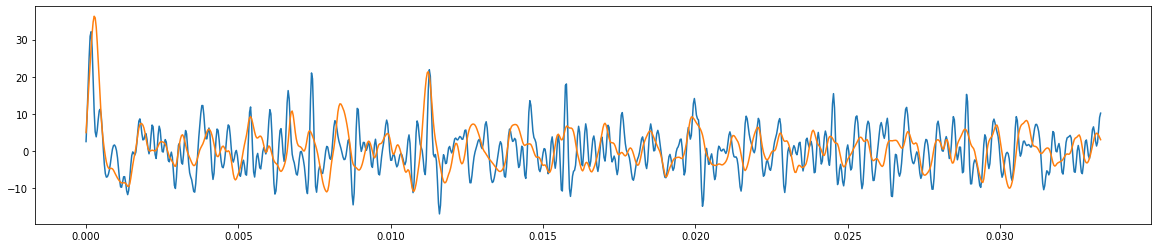

In [5]:
print(smoothed.shape)
start = 0
end = 1000
c = 4
fig, ax = plt.subplots(figsize = (20,4))
ax.plot(xs[start:end]/fs,ys[start:end,c])
ax.plot(xs[start:end]/fs,smoothed[start:end,c])
plt.savefig (datafile.replace('.h5','_smoothed_chan' + str(c) + '.png'))

## Search for events (based on Mean +/- SD of Smoothed signal)
- Search in 5s windows, get mean of smoothed data and sd
- from start to end of window find any peaks that are greater than 1 sd of baseline or compare MSE?
- save all data points from -3 to + 3 ms around peak and note the time of the peak
    - later look for overlap between epochs to determine wavelets vs single spikes 
    - i.e. granule cell activity from simple spikes
- Experimented with dataframes, np.arays, and dicts for working with these long lists of events and dataframes were the worst for speed

In [6]:
def event_search(raw, smooth, start, end, channels, thresh): 
    start = int(start * fs)
    end = int(end*fs)
    mn = fs-150 # minimum length of analysis window (0.995 s)
    peaks_x = {} # dict to catch peak times 
    peaks_y = {} # dict to catch peak amps
    peaks_b = {} # dict to catch peak baseline amps
    peaks_w = {} # dict to catch the peak width
    peaks_i = {} # dict to catch insterpeak intervals
    events_x = {} # dict to catch event trace x (3 ms before and after peak)
    events_y = {} # dict to catch event trace y (3 ms before and after peak)
    last_peak_x = np.nan # holds the time of the previous peak for calculating ipi
    print('Analyzing channel: ', end = ' ')
    for j in channels:
        print(j, end = ' ')
        i = start
        epoch = 0
        peak_x = []
        peak_y = []
        peak_b = []
        peak_w = []
        peak_i = []
        rep = 0
        while i < end-11: # search all the rows 
            if i % mn == 0 and i < end - mn: # moving window every 10ms
                savg = np.median(abs(smooth[i:i+mn,j]))
                ssd = np.std(smooth[i:i+mn,j])*thresh
            if raw[i,j] > savg  and raw[i,j] > max(raw[i+1:i+10,j]) and raw[i,j] > raw[i-1,j] and i-10 >= 0:
                peak_x.append(i)
                peak_y.append(raw[i,j])
                peak_b.append(savg)
                event_y = raw[i-10:i+10,j]
                events_x['xCh'+str(j)+'_'+str(rep)] = list(range(i-10,i+10))
                events_y['yCh'+str(j)+'_'+str(rep)] = event_y 
                for x in np.arange(10,0,-1):
                    if event_y[x] < event_y[(x-1)]:
                        tmp1 = x  
                for x in np.arange(11,19):
                    if event_y[x] > event_y[(x+1)]:
                        tmp2 = x
                peak_w.append(tmp2-tmp1)
                peak_i.append(i-last_peak_x)
                last_peak_x = i
                rep = rep + 1
            i = i + 1
        peaks_x[str(j)] = peak_x
        peaks_y[str(j)] = peak_y
        peaks_b[str(j)] = peak_b
        peaks_w[str(j)] = peak_w
        peaks_i[str(j)] = peak_i
    peaks = [peaks_x,peaks_y,peaks_b, peaks_w, peaks_i]
    events = [events_x, events_y]
    return peaks, events
            

# started at 11:40 PM, 2 mins for 30s on 1 channel on a macbook air with 8GB RAM
# at channel 32 at 11:52 PM 

# for all channels, 30s trace started at 1:39 PM. ch 16 at 1:47

channels = list(range(chan_num[0],chan_num[1]))
# Thresh is a multiplier of the std of the smoothed mean for every 10ms with 10% overlap
peaks, events = event_search (raw = ys, smooth = smoothed, start = 0, end = window[1]-window[0], 
                              channels = channels,thresh = thresh)            


Analyzing channel:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

- Cerebellar recordings, all spikes kept
- Will sort them and see if they cluster into granule cell activity, complex spikes, simple spikes

## Format final output
- takes a long time. DFs will add processing time, so if you have to pull data, do it from the peaks and events dictionaries, not the dataframe
- ids are 'Ch + channel# + event#'

In [7]:
f_out = open(datafile.replace('.h5','_events_' + str(window[0]) + '-' + str(window[1])+'.csv'), "w")
writer = csv.writer(f_out)
header = ['id','time_datapoints','time_seconds','peak_amplitude_microvolts','peak_width_datapoints',
          'peak_width_seconds','interpeak_interval_datapoints', 'interpeak_interval_seconds',
          'baseline_amplitude_microvolts']
writer.writerow(header)
print('Working on chan: ', end = ' ')
for chan in channels:
    # load the data for the channel upfront for speed
    str_chan = str(chan)
    row_range = range(len(peaks[0][str(chan)]))
    x_list = peaks[0][str_chan]
    y_list = peaks[1][str_chan]
    b_list = peaks[2][str_chan]
    w_list = peaks[3][str_chan]
    i_list = peaks[4][str_chan]
    print(chan, end = ' ')
    for i in row_range:
        x_dp = x_list[i]
        y = y_list[i]
        b = b_list[i]
        w = w_list[i]
        n = i_list[i]
        row = ['Ch'+str(chan)+str(x_dp),x_dp,(x_dp/fs),y, w, (w/fs), n, (n/fs), b]
        writer.writerow(row)
f_out.close()

Working on chan:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 